# Import all dependencies

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [2]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.13.0


# Set all the constants

In [3]:
BATCH_SIZE = 16
IMAGE_SIZE = 224
CHANNELS=3
EPOCHS=10

# Import data into tensorflow data object

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    r"C:\Users\USER\Downloads\diseasedetection\cashew",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2967 files belonging to 4 classes.


In [5]:
class_names = dataset.class_names
class_names

['cashew_anthracnose', 'cashew_gumosis', 'cashew_healthy', 'cashew_red rust']

In [6]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(16, 224, 224, 3)
[2 3 0 3 0 0 2 3 2 0 2 0 2 1 3 1]


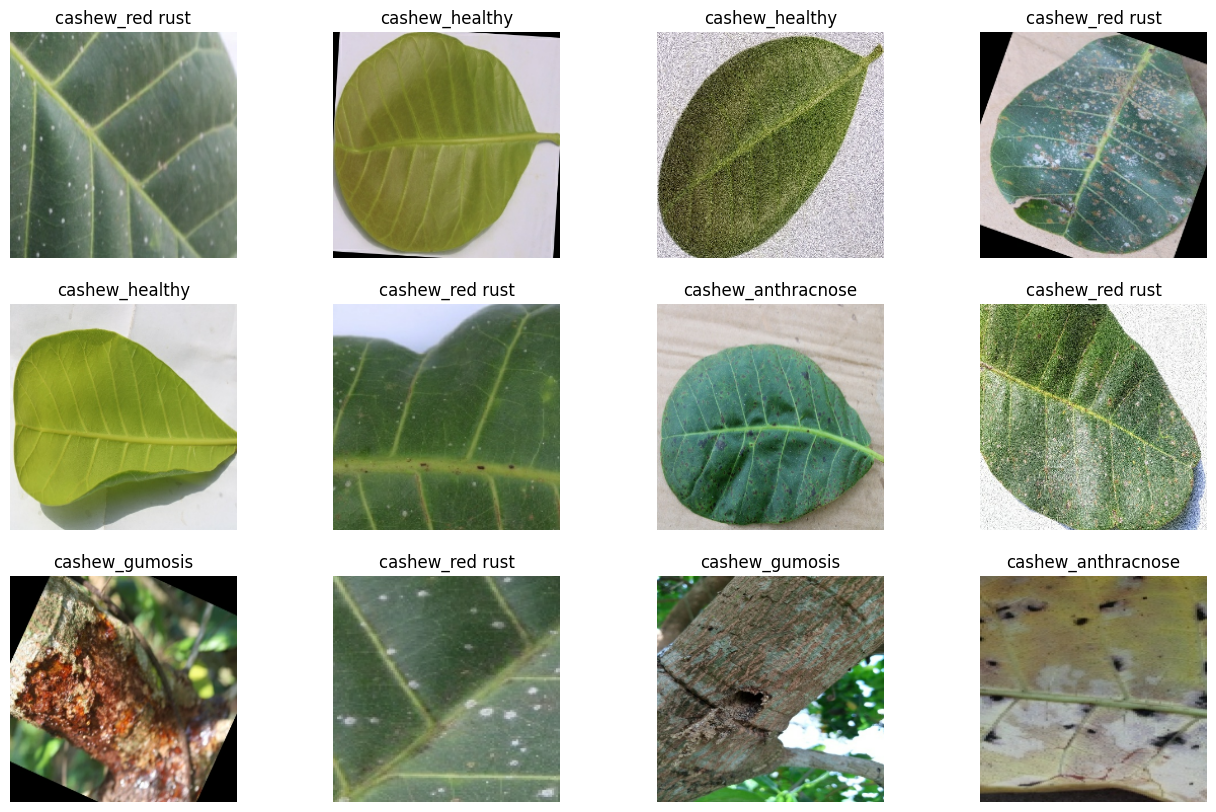

In [7]:
plt.figure(figsize=(16, 10))
for image_batch, labels_batch in dataset.take(1):
    batch_size = min(12, BATCH_SIZE)
    for i in range(batch_size):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")


In [8]:
len(dataset)

186

In [9]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [10]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [11]:
len(train_ds)

148

In [12]:
len(val_ds)

18

In [13]:
len(test_ds)

20

In [14]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [15]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [16]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [17]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)



In [18]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build()

In [19]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (16, 224, 224, 3)         0         
                                                                 
 conv2d (Conv2D)             (16, 222, 222, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (16, 111, 111, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (16, 109, 109, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (16, 54, 54, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (16, 52, 52, 64)         

In [42]:
from keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
    
  # Add class weights here
)


In [43]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=10,  # Increased the number of epochs
)

Epoch 1/10
148/148 [==============================] - 136s 901ms/step - loss: 0.2816 - accuracy: 0.9101 - val_loss: 0.2986 - val_accuracy: 0.8958
Epoch 2/10
148/148 [==============================] - 133s 899ms/step - loss: 0.2390 - accuracy: 0.9178 - val_loss: 0.3056 - val_accuracy: 0.9132
Epoch 3/10
148/148 [==============================] - 171s 1s/step - loss: 0.2125 - accuracy: 0.9351 - val_loss: 0.2667 - val_accuracy: 0.9236
Epoch 4/10
148/148 [==============================] - 203s 1s/step - loss: 0.2068 - accuracy: 0.9322 - val_loss: 0.2609 - val_accuracy: 0.9097
Epoch 5/10
148/148 [==============================] - 161s 1s/step - loss: 0.2016 - accuracy: 0.9339 - val_loss: 0.2206 - val_accuracy: 0.9271
Epoch 6/10
148/148 [==============================] - 124s 839ms/step - loss: 0.1915 - accuracy: 0.9390 - val_loss: 0.2847 - val_accuracy: 0.9062
Epoch 7/10
148/148 [==============================] - 124s 840ms/step - loss: 0.1783 - accuracy: 0.9428 - val_loss: 0.2012 - val_accu

In [44]:
#scores = model.evaluate(test_ds)

test_loss, test_accuracy = model.evaluate(test_ds)


20/20 [==============================] - 5s 237ms/step - loss: 0.1170 - accuracy: 0.9594


In [45]:
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss:     0.11703039705753326
Test Accuracy: 0.9593750238418579


In [46]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Assuming you have the model predictions and true labels
y_true = np.concatenate([y.numpy() for x, y in test_ds], axis=0)
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)
print(y_pred)
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

print("Confusion Matrix:")
print(conf_matrix)


20/20 [==============================] - 5s 244ms/step
[3 0 2 0 3 3 0 2 2 1 0 0 2 1 0 3 3 1 0 2 2 2 2 3 3 1 2 0 1 0 0 2 1 1 1 1 1
 1 2 0 1 3 0 2 2 1 3 0 2 0 1 3 2 1 1 3 0 2 2 2 2 0 0 0 3 0 1 3 3 1 3 0 3 2
 1 0 0 1 3 0 1 3 2 1 0 2 1 1 0 3 1 1 0 1 3 3 1 0 2 3 1 2 1 1 0 1 2 2 3 1 1
 1 0 3 1 3 1 0 0 0 1 1 3 3 3 1 3 2 1 0 2 1 1 0 3 1 0 3 1 0 3 2 1 3 2 0 0 1
 0 2 1 1 1 0 1 1 3 3 3 3 2 0 1 1 2 2 0 0 2 2 1 0 2 1 0 2 2 0 1 3 0 3 0 3 2
 0 3 0 0 2 2 2 1 0 1 1 0 1 1 0 1 3 3 0 0 1 2 3 3 0 3 3 1 0 3 0 2 0 2 2 0 2
 0 2 0 3 2 0 3 1 2 0 2 3 2 3 2 3 1 3 2 2 1 1 0 3 0 0 3 2 0 2 0 2 2 1 2 2 2
 1 2 3 0 2 1 0 3 2 3 2 0 0 3 2 1 2 2 2 2 3 1 2 0 0 2 2 0 1 2 2 3 3 0 3 2 0
 2 3 0 2 0 3 1 1 1 0 0 2 3 3 2 1 1 0 3 0 1 3 0 1]
Confusion Matrix:
[[27 20 21 22]
 [22 29 15 12]
 [21 16 31 16]
 [16 17 15 20]]


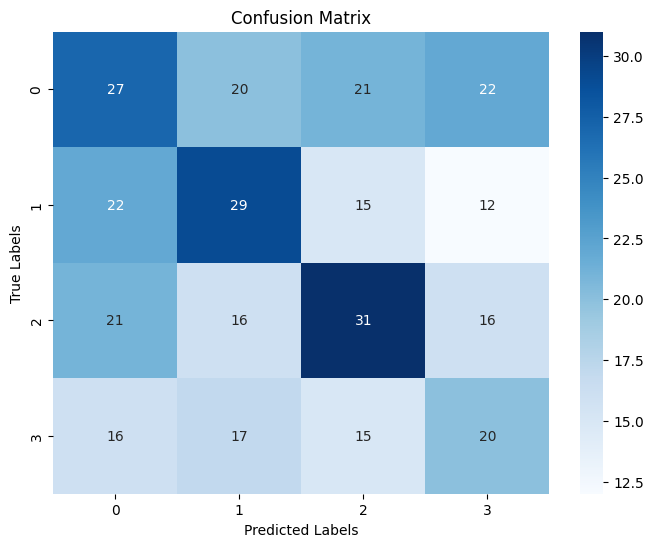

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

num_classes = 4
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [48]:
from sklearn.metrics import confusion_matrix, classification_report
# Generate classification report
class_report = classification_report(y_true, y_pred)

print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       0.31      0.30      0.31        90
           1       0.35      0.37      0.36        78
           2       0.38      0.37      0.37        84
           3       0.29      0.29      0.29        68

    accuracy                           0.33       320
   macro avg       0.33      0.33      0.33       320
weighted avg       0.33      0.33      0.33       320



In [49]:
#scores

In [50]:
history

In [51]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 148}

In [52]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [53]:
type(history.history['loss'])

list

In [54]:
len(history.history['loss'])

10

In [55]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.28162628412246704,
 0.23895253241062164,
 0.2124754935503006,
 0.2067599892616272,
 0.2016083300113678]

In [56]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

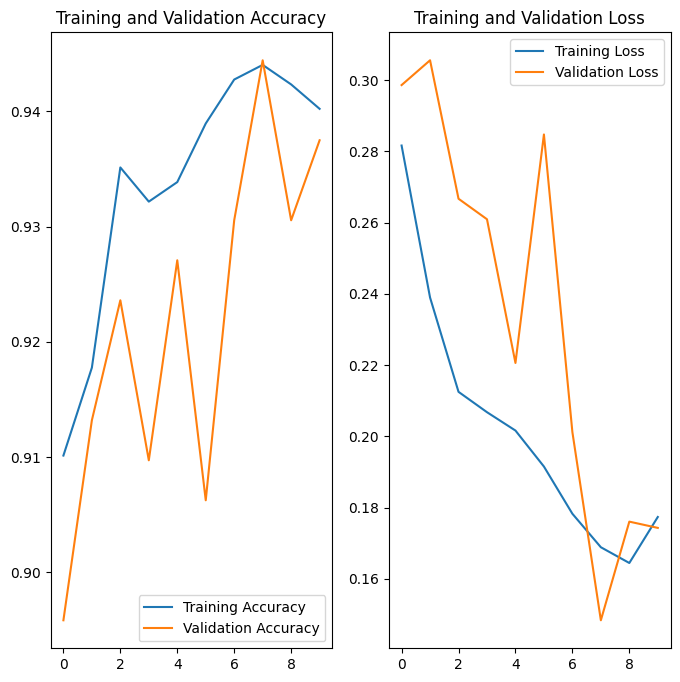

In [57]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: cashew_red rust
1/1 [==============================] - 1s 604ms/step
predicted label: cashew_red rust


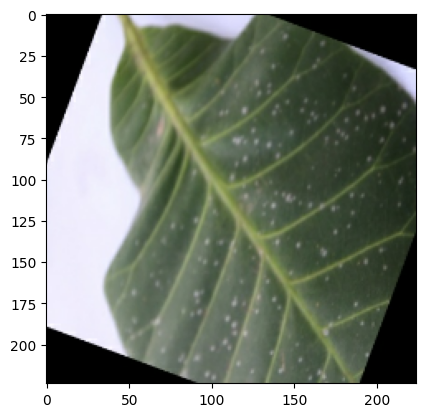

In [58]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [59]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 36ms/step


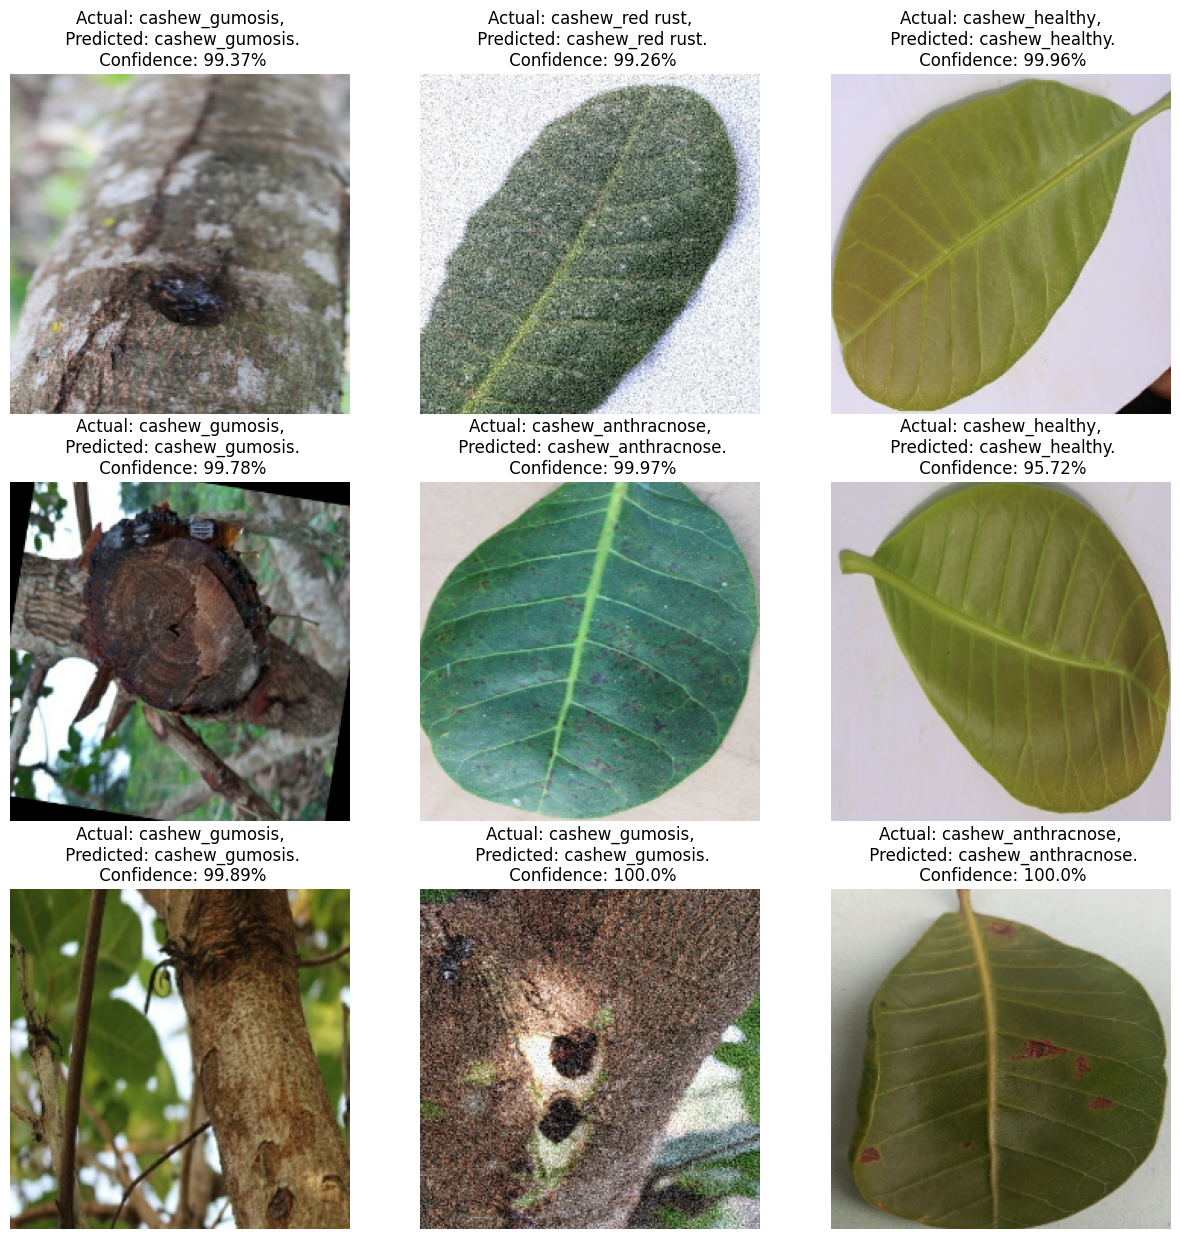

In [60]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [2]:
import os

# Get all directories in "../models"
directory_path = r"C:\Users\USER\Downloads\diseasedetection\new models"
directories = [d for d in os.listdir(directory_path) if os.path.isdir(os.path.join(directory_path, d))]

# Extract numeric parts from directory names
versions = [int(''.join(filter(str.isdigit, d))) for d in directories if any(char.isdigit() for char in d)]

# Find the maximum version number
model_version = max(versions + [0]) + 1

# Save the model
model.save(os.path.join(directory_path, str(model_version), "cashew.h5"))


NameError: name 'model' is not defined